2.4.1


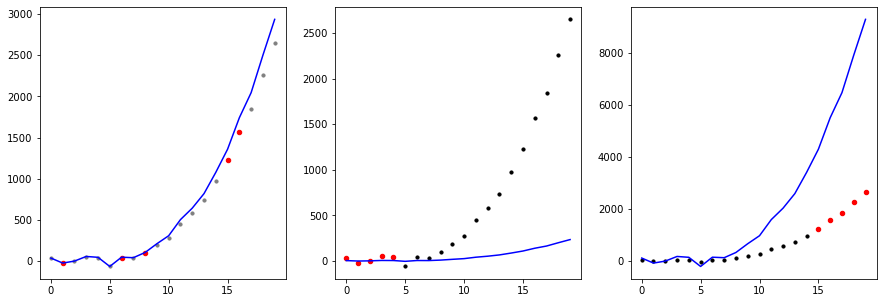

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
print(tf.__version__)
# 현재 model.predict() 의 속도가 느린 문제가 있어서 eager_execution을 끔
tf.compat.v1.disable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

np.random.seed(0)
x = np.array(range(20))
y = x - 2 * (x ** 2) + 0.5 * (x ** 3) + np.random.normal(-40, 40, 20)
x = np.reshape(x, (-1, 1))
y = np.reshape(y, (-1, 1))

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.scatter(x,y, s=10, color='gray')

select = np.random.choice(20, 5, replace=False)
select.sort()
clf = Ridge(alpha=100, normalize=True)
clf.fit(x[select], y[select])

plt.scatter(x[select], y[select], s=20, color='r')
plt.plot(x, clf.predict(y) - clf.intercept_, color='blue')


plt.subplot(1, 3, 2)
plt.scatter(x,y, s=10, color='k')

select = np.array(range(5))
clf = Ridge(alpha=100, normalize=True)
clf.fit(x[select], y[select])

plt.scatter(x[select], y[select], s=20, color='r')
plt.plot(x, clf.predict(y) - clf.intercept_, color='blue')


plt.subplot(1, 3, 3)
plt.scatter(x,y, s=10, color='k')

select = np.array(range(15, 20))
clf = Ridge(alpha=100, normalize=True)
clf.fit(x[select], y[select])

plt.scatter(x[select], y[select], s=20, color='r')
plt.plot(x, clf.predict(y) - clf.intercept_, color='blue')



plt.show()


In [2]:
!pip install gym_2048 --no-dependencies

In [3]:
import gym_2048
import gym

env = gym.make('2048-v0')
obs = env.reset()

print(obs)
print(env.observation_space)
print(env.action_space)

obs, _, _, _ = env.step(0)
print(obs)

[[0 0 0 0]
 [0 0 0 0]
 [0 2 0 2]
 [0 0 0 0]]
Box(4, 4)
Discrete(4)
[[0 0 0 0]
 [0 0 2 0]
 [4 0 0 0]
 [0 0 0 0]]


C:\Users\Mr_K\anaconda3\lib\site-packages\gym_2048\env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles


In [4]:
score = 0
step = 0
obs = env.reset()

while True:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    
    score += reward
    step += 1
    if done:
        break
        
print('score:', score, 'step:', step)
print(obs)

score: 672 step: 91
[[ 2  8  2  8]
 [16 64 32  2]
 [ 4 32  2  8]
 [ 2  4  8  4]]


In [5]:
layer_count = 12
table = {2**i:i for i in range(layer_count)}
print(table)

def preprocess(obs):    
    x = np.zeros((4, 4, layer_count))
    for i in range(4):
        for j in range(4):
            if obs[i,j] > 0:
                v = min(obs[i,j], 2**(layer_count-1))
                x[i,j,table[v]] = 1
            else:
                x[i,j,0] = 1
    return x

{1: 0, 2: 1, 4: 2, 8: 3, 16: 4, 32: 5, 64: 6, 128: 7, 256: 8, 512: 9, 1024: 10, 2048: 11}


In [6]:
def build_model():
    dense1 = 128
    dense2 = 128

    x = tf.keras.Input(shape=(4, 4, layer_count))

    conv_a = tf.keras.layers.Conv2D(dense1, kernel_size=(2,1), activation='relu')(x)
    conv_b = tf.keras.layers.Conv2D(dense1, kernel_size=(1,2), activation='relu')(x)

    conv_aa = tf.keras.layers.Conv2D(dense2, kernel_size=(2,1), activation='relu')(conv_a)
    conv_ab = tf.keras.layers.Conv2D(dense2, kernel_size=(1,2), activation='relu')(conv_a)
    conv_ba = tf.keras.layers.Conv2D(dense2, kernel_size=(2,1), activation='relu')(conv_b)
    conv_bb = tf.keras.layers.Conv2D(dense2, kernel_size=(1,2), activation='relu')(conv_b)

    flat = [tf.keras.layers.Flatten()(a) for a in [conv_a, conv_b, conv_aa, conv_ab, conv_ba, conv_bb]]

    concat = tf.keras.layers.Concatenate()(flat)
    dense1 = tf.keras.layers.Dense(256, activation='relu')(concat)
    out = tf.keras.layers.Dense(4, activation='linear')(dense1)

    model = tf.keras.Model(inputs=x, outputs=out)
    model.compile(optimizer=tf.optimizers.RMSprop(learning_rate=0.0005), loss='mse')
    # model.summary()
    return model

model = build_model()
target_model = build_model()

In [7]:
gamma = 0.9
batch_size = 512
max_memory = batch_size*8
memory = []

def append_sample(state, action, reward, next_state, done):
    memory.append([state, action, reward, next_state, done])

def train_model():
    np.random.shuffle(memory)

    len = max_memory // batch_size
    for k in range(len):
        mini_batch = memory[k*batch_size:(k+1)*batch_size]

        states = np.zeros((batch_size, 4, 4, layer_count))
        next_states = np.zeros((batch_size, 4, 4, layer_count))
        actions, rewards, dones = [], [], []

        for i in range(batch_size):
            states[i] = mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            next_states[i] = mini_batch[i][3]
            dones.append(mini_batch[i][4])

        target = model.predict(states)
        next_target = target_model.predict(next_states)

        for i in range(batch_size):
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                target[i][actions[i]] = rewards[i] + gamma * np.amax(next_target[i])

        model.fit(states, target, batch_size=batch_size, epochs=1, verbose=0)

In [ ]:
import math
import random

def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits))
    sum_exp_logits = np.sum(exp_logits)
    return exp_logits / sum_exp_logits

max_episodes = 10001
epsilon = 0.9
epsilon_min = 0.1

scores = []
steps = []
iteration = 0

train_count = 0

for i in range(max_episodes):
    if i % 100 == 0 and i != 0:
        print('score mean:', np.mean(scores[-100:]), 'step mean:', np.mean(steps[-100:]), 'iteration:', iteration, 'epsilon:', epsilon)

    prev_obs = env.reset()

    score = 0
    step = 0
    not_move_list = np.array([1,1,1,1])
    prev_max = np.max(prev_obs)

    while True:
        iteration += 1

        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            x = preprocess(prev_obs)
            logits = model.predict(np.expand_dims(x, axis=0))[0]
            prob = softmax(logits)
            prob = prob * not_move_list
            action = np.argmax(prob)

        obs, reward, done, info = env.step(action)

        score += reward
        step += 1

        # not moved situation
        if reward == 0 and np.array_equal(obs, prev_obs):
            not_move_list[action] = 0
            continue
        else:
            not_move_list = np.array([1,1,1,1])

        # custom reward
        now_max = np.max(obs)
        if prev_max < now_max:
            prev_max = now_max
            reward = math.log(now_max, 2) * 0.1
        else:
            reward = 0

        reward += np.count_nonzero(prev_obs) - np.count_nonzero(obs) + 1

        append_sample(preprocess(prev_obs), action, reward, preprocess(obs), done)

        if len(memory) >= max_memory:
            train_model()
            memory = []

            train_count += 1
            if train_count % 4 == 0:
                target_model.set_weights(model.get_weights())

        prev_obs = obs

        if epsilon > 0.01 and iteration % 2500 == 0:
            epsilon = epsilon / 1.005

        if done:
            break

    scores.append(score)
    steps.append(step)

    print(i, 'score:', score, 'step:', step, 'max tile:', np.max(obs), 'memory len:', len(memory))

C:\Users\Mr_K\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


0 score: 1296 step: 150 max tile: 128 memory len: 137
1 score: 732 step: 112 max tile: 64 memory len: 234
2 score: 588 step: 82 max tile: 64 memory len: 316
3 score: 660 step: 92 max tile: 64 memory len: 404
4 score: 908 step: 105 max tile: 128 memory len: 502
5 score: 1476 step: 159 max tile: 128 memory len: 649
6 score: 696 step: 91 max tile: 64 memory len: 740
7 score: 1312 step: 134 max tile: 128 memory len: 874
8 score: 376 step: 61 max tile: 32 memory len: 935
9 score: 1176 step: 125 max tile: 128 memory len: 1060
10 score: 592 step: 82 max tile: 64 memory len: 1141
11 score: 852 step: 106 max tile: 64 memory len: 1245
12 score: 1352 step: 136 max tile: 128 memory len: 1378
13 score: 512 step: 69 max tile: 64 memory len: 1446
14 score: 2220 step: 198 max tile: 256 memory len: 1627
15 score: 1000 step: 124 max tile: 64 memory len: 1746
16 score: 1104 step: 119 max tile: 128 memory len: 1865
17 score: 1020 step: 130 max tile: 64 memory len: 1989
18 score: 1428 step: 151 max tile: 1

In [ ]:
import matplotlib.pyplot as plt

N = 100
rolling_mean = [np.mean(scores[x:x+N]) for x in range(len(scores)-N+1)]

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.scatter(range(len(scores)), scores, marker='.')
plt.subplot(1, 2, 2)
plt.plot(rolling_mean)
plt.show()

In [ ]:
max_memory = 512*64

action_swap_array = [[0, 0, 2, 2, 1, 3, 1, 3],
                     [1, 3, 1, 3, 0, 0, 2, 2],
                     [2, 2, 0, 0, 3, 1, 3, 1],
                     [3, 1, 3, 1, 2, 2, 0, 0]]

def append_sample(state, action, reward, next_state, done):
    g0 = state
    g1 = g0[::-1,:,:]
    g2 = g0[:,::-1,:]
    g3 = g2[::-1,:,:]
    r0 = state.swapaxes(0,1)
    r1 = r0[::-1,:,:]
    r2 = r0[:,::-1,:]
    r3 = r2[::-1,:,:]

    g00 = next_state
    g10 = g00[::-1,:,:]
    g20 = g00[:,::-1,:]
    g30 = g20[::-1,:,:]
    r00 = next_state.swapaxes(0,1)
    r10 = r00[::-1,:,:]
    r20 = r00[:,::-1,:]
    r30 = r20[::-1,:,:]

    states = [g0, g1, g2, g3, r0, r1, r2, r3]
    next_states = [g00, g10, g20, g30, r00, r10, r20, r30]

    for i in range(8):
        memory.append([
            states[i],
            action_swap_array[action][i],
            reward,
            next_states[i],
            done
        ])

In [ ]:
max_episodes = 10001
epsilon = 0.9
epsilon_min = 0.1

scores = []
steps = []
iteration = 0
train_count = 0

for i in range(max_episodes):
    if i % 100 == 0 and i != 0:
        print('score mean:', np.mean(scores[-100:]), 'step mean:', np.mean(steps[-100:]), 'iteration:', iteration, 'epsilon:', epsilon)

    prev_obs = env.reset()

    score = 0
    step = 0
    not_move_list = np.array([1,1,1,1])
    prev_max = np.max(prev_obs)

    while True:
        iteration += 1

        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            x = preprocess(prev_obs)
            logits = model.predict(np.expand_dims(x, axis=0))[0]
            prob = softmax(logits)
            prob = prob * not_move_list
            action = np.argmax(prob)

        obs, reward, done, info = env.step(action)

        score += reward
        step += 1

        # not moved situation
        if reward == 0 and np.array_equal(obs, prev_obs):
            not_move_list[action] = 0
            continue
        else:
            not_move_list = np.array([1,1,1,1])

        # custom reward
        now_max = np.max(obs)
        if prev_max < now_max:
            prev_max = now_max
            reward = math.log(now_max, 2) * 0.1
        else:
            reward = 0

        reward += np.count_nonzero(prev_obs) - np.count_nonzero(obs) + 1

        append_sample(preprocess(prev_obs), action, reward, preprocess(obs), done)

        if len(memory) >= max_memory:
            train_model()
            memory = []

            train_count += 1
            if train_count % 4 == 0:
                target_model.set_weights(model.get_weights())

        prev_obs = obs

        if epsilon > 0.01 and iteration % 2500 == 0:
            epsilon = epsilon / 1.005

        if done:
            break

    scores.append(score)
    steps.append(step)

    print(i, 'score:', score, 'step:', step, 'max tile:', np.max(obs), 'memory len:', len(memory))